In [ ]:
'''3.1.2 通过特征筛选来寻找最佳的特征组合'''

In [8]:
# 导入pandas并更名为pd
import pandas as pd
# 从互联网读取titanic数据
titanic = pd.read_csv('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.txt')

In [17]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 11 columns):
row.names    1313 non-null int64
pclass       1313 non-null object
survived     1313 non-null int64
name         1313 non-null object
age          633 non-null float64
embarked     821 non-null object
home.dest    754 non-null object
room         77 non-null object
ticket       69 non-null object
boat         347 non-null object
sex          1313 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 112.9+ KB


In [19]:
# 分离数据特征与预测目标
y = titanic['survived']
X = titanic.drop(['row.names', 'name', 'survived'], axis=1)

# 对缺失数据进行填充 
# fillna返回一个新对象，inplace = True 可以就地填充
X['age'].fillna(X['age'].mean(), inplace=True)
X.fillna('UnKNOWN', inplace=True)

print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 8 columns):
pclass       1313 non-null object
age          1313 non-null float64
embarked     1313 non-null object
home.dest    1313 non-null object
room         1313 non-null object
ticket       1313 non-null object
boat         1313 non-null object
sex          1313 non-null object
dtypes: float64(1), object(7)
memory usage: 82.1+ KB
None


In [18]:
# 分割数据，依然采样25%用于测试
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

# 类别型特征向量化
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
# dateframe.to_dict() 就是把dateframe转换成字典，但是orient='record'表示结果为 list， like [{column -> value}, ... , {column -> value}]
X_train = vec.fit_transform(X_train.to_dict(orient='record')) 
X_test = vec.transform(X_test.to_dict(orient='record'))

# 输出处理后的特征向量维度
print(len(vec.feature_names_))

474


In [15]:
# 使用决策树模型依靠所有特征进行预测，并作性能评估
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='entropy') # 使用信息熵作为划分标准，对决策树进行训练 
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.8297872340425532

In [29]:
# 从sklearn中导入特征筛选器
from sklearn import feature_selection
# 筛选前5%的特征，使用相同配置的决策树模型进行预测，并且评估性能
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=5)
X_train_fs = fs.fit_transform(X_train, y_train)
dt.fit(X_train_fs, y_train)
X_test_fs = fs.transform(X_test)
dt.score(X_test_fs, y_test)

0.851063829787234

In [32]:
# 通过交叉验证的方法，按照固定间隔的百分比筛选特征，并作图展示性能随特征筛选比例的变化
from sklearn.cross_validation import cross_val_score
import numpy as np
percentiles = range(1, 100, 2)
results = []

for i in percentiles:
    fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=i) # chi2卡方检验
    X_train_fs = fs.fit_transform(X_train, y_train)
    scores = cross_val_score(dt, X_train_fs, y_train, cv=5) # cv:交叉验证的迭代词数
    results = np.append(results, scores.mean()) 
    
print(results)

[0.85063904 0.85673057 0.87501546 0.88622964 0.87308802 0.87816945
 0.87613894 0.87611833 0.86900639 0.87207792 0.87306741 0.87409812
 0.87206761 0.86491445 0.86898578 0.86796537 0.86999588 0.86490414
 0.8710369  0.86697588 0.86897547 0.86694496 0.87407751 0.87105751
 0.87001649 0.87000618 0.87404659 0.87508761 0.86794475 0.87508761
 0.87407751 0.87404659 0.87508761 0.87402597 0.87201608 0.8760874
 0.8760771  0.875067   0.87101629 0.87098536 0.8760771  0.87199546
 0.86693465 0.86897547 0.87203669 0.87101629 0.86694496 0.86591424
 0.86286333 0.85982272]


In [43]:
# 找到体现最佳性能的特征筛选的百分比
opt = np.where(results == results.max())[0]
print(type(opt))

<class 'numpy.ndarray'>


In [44]:
# 因为opt的类型是numpy.ndarray,所以输出时要先转为整数
print('Optimal number of features %d' % percentiles[int(opt)])

Optimal number of features 7


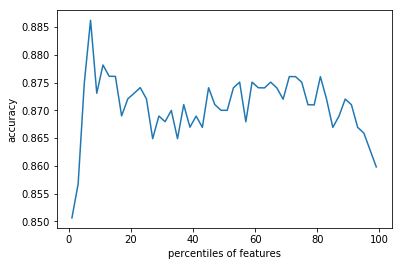

In [48]:
import pylab as pl
pl.plot(percentiles, results)
pl.xlabel('percentiles of features')
pl.ylabel('accuracy')
pl.show()

In [51]:
# 使用最佳筛选后的特征，利用相同配置的模型在测试集上进行性能评估
from sklearn import feature_selection
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=7)
X_train_fs = fs.fit_transform(X_train, y_train)
dt.fit(X_train_fs, y_train)
X_test_fs = fs.transform(X_test)
dt.score(X_test_fs, y_test)

0.8601823708206687